In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import xarray as xr
import matplotlib.pyplot as plt
import dask
import xesmf as xe
import proplot as pplt
import cartopy.feature as cfeature
import xskillscore as xs

import warnings
warnings.filterwarnings("ignore")

In [3]:
def getFields():
    tfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.1979-2018.nc'
    zfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.*.nc'
    ufiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.*.nc'
    vfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.v.*.nc'

    print("READING Z")
    # Z500 and Z850
    ds_z=xr.open_mfdataset(zfiles,combine='by_coords',chunks={'time':-1})
    ds_z500=ds_z.sel(level=500).rename({'z':'z500'})
    ds_z850=ds_z.sel(level=850).rename({'z':'z850'})

    print("READING U")
    # U200 and U850
    ds_u=xr.open_mfdataset(ufiles,combine='by_coords',chunks={'time':-1})
    ds_u200=ds_u.sel(level=200).rename({'u':'u200'})
    ds_u850=ds_u.sel(level=850).rename({'u':'u850'})
    
    print("READING V")
    # V200 and V850
    ds_v=xr.open_mfdataset(vfiles,combine='by_coords',chunks={'time':-1})
    ds_v200=ds_v.sel(level=200).rename({'v':'v200'})
    ds_v850=ds_v.sel(level=850).rename({'v':'v850'})

    print("READING SST")
    # SST
    ds_sst=xr.open_dataset(tfiles,chunks={'time':-1})
    ds_sst=ds_sst.sel(time=ds_sst['time.hour']==0)

    print("READING OLR")
    # OLR
    olrfiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.19*s.nc'
    olrfiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.20*s.nc'
    ds_olr1=xr.open_mfdataset(olrfiles1,combine='by_coords',combine_attrs='drop_conflicts',chunks={'time':-1})
    ds_olr1['time']=ds_olr1['time'].dt.floor('d')
    ds_olr2=xr.open_mfdataset(olrfiles2,combine='by_coords',chunks={'time':-1})
    ds_olr=xr.combine_by_coords([ds_olr1,ds_olr2],combine_attrs='drop_conflicts').rename({'ttr':'olr'})
    ds_olr['olr']=ds_olr['olr']*-1
    
    print("COARSE GRAIN")
    # Coarse Grain Data
    new_lon=np.arange(0,360,5)
    new_lat=np.arange(-90,92,5)

    ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                         'lon': (['lon'], new_lon)})

    regridder = xe.Regridder(ds_z500,ds_out,'bilinear',periodic=True)
    ds_z500=regridder(ds_z500)
    ds_z850=regridder(ds_z850)
    ds_olr=regridder(ds_olr)
    ds_u200=regridder(ds_u200)
    ds_u850=regridder(ds_u850)
    ds_v200=regridder(ds_v200)
    ds_v850=regridder(ds_v850)


    regridder_sst = xe.Regridder(ds_sst,ds_out,'bilinear',periodic=True)
    ds_sst=regridder_sst(ds_sst)
    
    print("MERGE")
    ds=xr.merge([ds_sst,ds_z500,ds_z850,ds_olr,ds_u850,ds_v850,ds_u200,ds_v200],compat='override')
     
    print("ANOMS")
    ds_anoms=ds.groupby('time.dayofyear')-ds.groupby('time.dayofyear').mean()
    
    return ds_anoms

In [4]:
def rednoise(ds,h):
    
    
    lags=[1,2]
    red_list=[]
    for v in list(ds.keys()):
        x=ds[v]
        corr_list=[]
        for l in lags:
            _,cor,_,_,_,_=lag_linregress_3D(x, x, lagx=0, lagy=l)
            corr_list.append(cor.values)
  
        rho=0.5*(corr_list[0]+np.sqrt(corr_list[1]))
        Te=-1/np.log(rho)
        
        print(v,rho,Te)
        numerator=1-rho**2
        denomenator=1-(2*rho*np.cos(h*np.pi/np.max(h)))+rho**2
        red=numerator/denomenator
        red_list.append(red)
    
    return red_list

In [5]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [6]:
def powerSpectra(ds_ts,w):
    
    P_list=[]
    for v in list(ds_ts.keys()):
        
        x=ds_ts[v].values
        x = x[~np.isnan(x)]
        f, P = signal.welch(x,detrend=False,nperseg=w,scaling='spectrum')
        ds_P=xr.DataArray(P,coords={'freq':f},dims=['freq']).to_dataset(name=v)

        P_list.append(ds_P)
        
    ds=xr.merge(P_list)
    return ds

In [7]:
def getTS(ds_anoms,ds_comp,seas,file=''):
    
    nt=len(ds_anoms['time'])
    nx=len(ds_anoms['lon'])
    ny=len(ds_anoms['lat'])
    
    ds_anoms=ds_anoms.fillna(0.0)
    ds_comp=ds_comp.fillna(0.0)
    
    var_list=[]         
    for v in list(ds_anoms.keys()):
                 
        anoms=ds_anoms[v].values.reshape(nt,nx*ny)
        comp=ds_comp[v].sel(seas=seas).values.reshape(nx*ny)
        
        ts=np.matmul(anoms,comp)
    
        ds_ts=xr.DataArray(ts,coords={'time':ds_anoms['time']},
                           dims=['time']).to_dataset(name=v)

        var_list.append(ds_ts)
                 
    ds_var=xr.merge(var_list)
                     
    return ds_var

In [78]:
def plotCompLRPCirc(ds_tmp,ds_comp,file=''):

    lon_0=290
    levs_z500=np.arange(-1800,1900,200)
    levs_z850=np.arange(-900,1000,100)
    levs_u200=np.arange(-10,12,2)
    levs_u850=np.arange(-10,12,2)
    levs_lrp=np.arange(0.4,0.8,0.05)
    
    f, axs = pplt.subplots(ncols=2, nrows=2,
                           proj=['npstere','npstere','npstere','npstere'],
                           proj_kw={'lon_0': lon_0},width=8.5,height=11.0)

    for i,seas in enumerate(['DJF','JJA']):
    

        #Z500 with LRP
        m=axs[i,0].pcolormesh(ds_tmp['lon'],ds_tmp['lat'],
              ds_tmp.sel(seas=seas,var='z500'),cmap='grays',extend='both',levels=levs_lrp)
        axs[i,0].format(coast=True,grid=True,title=seas+' Z500',abc=True)
        Q=axs[i,0].quiver(ds_comp['lon'],ds_comp['lat'],
                ds_comp['u200'].sel(seas=seas).values,ds_comp['v200'].sel(seas=seas).values,
                          color='g',units='inches')
        axs[i,0].contour(ds_comp['lon'],ds_comp['lat'],ds_comp['z500'].sel(seas=seas),
                         levels=levs_z500,cmap='BR')

        #Z850 with LRP
        m=axs[i,1].pcolormesh(ds_tmp['lon'],ds_tmp['lat'],
              ds_tmp.sel(seas=seas,var='z850'),cmap='grays',extend='both',levels=levs_lrp)
        axs[i,1].format(coast=True,grid=True,title=seas+' Z850',abc=True)
        axs[i,1].quiver(ds_comp['lon'],ds_comp['lat'],
                ds_comp['u850'].sel(seas=seas).values,ds_comp['v850'].sel(seas=seas).values,
                        color='g',units='inches')
        axs[i,1].contour(ds_comp['lon'],ds_comp['lat'],ds_comp['z850'].sel(seas=seas),
                         levels=levs_z850,cmap='BR')
    axs[-1,-1].quiverkey(Q, 7.75, 0.6, 5, r'$5  ms^{-1}$', labelpos='S',
                         coordinates='inches',color='g',
                         fontproperties={'size':12},labelsep=0.1)
    f.colorbar(m,loc='b',length=0.7,label='Relevance')
    f.save(file)
    

In [80]:
def plotCompLRPGlobe(ds_tmp,ds_comp,file=''):

    lon_0=290
    levs_sst=np.arange(-1.4,1.6,0.2)
    levs_olr=np.arange(-25,30,5)
    levs_lrp=np.arange(0.4,0.8,0.05)
    
    f, axs = pplt.subplots(ncols=2, nrows=2,
                           proj=['robin','robin','robin','robin'],
                           proj_kw={'lon_0': lon_0},width=11.0,height=8.5)

    for i,seas in enumerate(['DJF','JJA']):


        # SST
        m=axs[i,0].pcolormesh(ds_tmp['lon'],ds_tmp['lat'],
              ds_tmp.sel(seas=seas,var='sst'),cmap='grays',extend='both',levels=levs_lrp)

        axs[i,0].format(land=True,landcolor='black',grid=True,
                        title=seas+' SST',abc=True)
        axs[i,0].contour(ds_comp['lon'],ds_comp['lat'],ds_comp['sst'].sel(seas=seas),
                         levels=levs_sst,cmap='BR')

        #OLR
        m=axs[i,1].pcolormesh(ds_tmp['lon'],ds_tmp['lat'],
              ds_tmp.sel(seas=seas,var='olr'),cmap='grays',extend='both',levels=levs_lrp)
        axs[i,1].format(coast=True,grid=True,title=seas+' OLR',abc=True)
        axs[i,1].contour(ds_comp['lon'],ds_comp['lat'],ds_comp['olr'].sel(seas=seas),
                         levels=levs_olr,cmap='BR')

    f.colorbar(m,loc='b',length=0.7,label='Relevance')
    f.save(file)

In [10]:
def hist_multipanel(ds_model,hist_bins,labels,fname=''):
    
    f,axs=pplt.subplots(nrows=len(ds_model['seas'].values),
                        ncols=len(ds_model['model_type'].values))

    for i,seas in enumerate(ds_model_indices['seas'].values):
        for j,(mtype,l) in enumerate(zip(ds_model['model_type'].values,labels)):

            print(seas,mtype,i,j)
       
            hs=[]
    
            # Select the model type
            ds=ds_model.sel(model_type=mtype,seas=seas)
            h=axs[i,j].hist(ds['acc'].values*100,hist_bins,edgecolor='k',color='b',alpha=0.6)
            hs.append(h)
    
            h=axs[i,j].hist(ds['val_acc'].values*100,hist_bins,edgecolor='k',color='g',alpha=0.6)
            hs.append(h)
    
            # Format subplot panel
            axs[i,j].format(title=l+' '+seas,abc=True)
    # Add custom legend
    axs[0,0].legend(hs, labels=['Train','Test'],ncols=1, loc='ur') 
        
        

In [11]:
def make_cm(ds_all,file=''):   

    f, axs = pplt.subplots(ncols=1,nrows=2)

    for iplot,seas in enumerate(['DJF','JJA']):
        
        ds=ds_all.sel(seas=seas)
        
        # Get Counts
        tp=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']==ds['verif'],ds['pred']==1))))
        tn=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']==ds['verif'],ds['pred']==0))))
        fp=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']!=ds['verif'],ds['pred']==1))))
        fn=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']!=ds['verif'],ds['pred']==0))))
    
        array=[[fp,tn],
               [tp,fn]]
    
        print('TP: ',tp,' FP: ',fp,' TN: ',tn,' FN: ',fn)
        df = pd.DataFrame(array, ['True Negative',
                                  'True Positive'], 
                          ['Predicted Positive',
                           'Predicted Negative'])


        axs[iplot].heatmap(df,labels=True,cmap='viridis') 
        axs[iplot].format(title=seas,abc=True)

    f.save(file)
    return

### Read in Model Output

In [12]:
fnames_indices='../data/fnn/model_output.*.nc'
ds_model_indices=xr.open_mfdataset(fnames_indices,combine='nested',concat_dim='seas')
ds_model_indices['seas']=['DJF','JJA']
ds_model_indices

<xarray.Dataset>
Dimensions:     (time: 6083, features: 10, rules: 2, seas: 2, model_type: 2, model: 100, cat: 2)
Coordinates:
  * time        (time) datetime64[ns] 1980-06-03 1980-06-04 ... 2015-02-28
  * features    (features) object 'RMM_amp' 'RMM_phase' ... 'pdo' 'pnaregimes'
  * rules       (rules) object 'lrp.alpha_1_beta_0' 'lrp.z'
  * model       (model) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * cat         (cat) object 'Lower' 'Upper'
    dayofyear   (time) float64 dask.array<chunksize=(6083,), meta=np.ndarray>
  * model_type  (model_type) object 'logmodel_med' 'nnmodel_med'
  * seas        (seas) <U3 'DJF' 'JJA'
Data variables:
    lrp         (seas, model_type, model, rules, time, features) float32 dask.array<chunksize=(1, 2, 100, 2, 6083, 10), meta=np.ndarray>
    pred        (seas, model_type, model, time) float64 dask.array<chunksize=(1, 2, 100, 6083), meta=np.ndarray>
    verif       (seas, model_type, model, time) float64 dask.array<chunksize=(1, 2, 100, 6083), meta=np.ndarray>
    probs       (seas, model_type, model, time, cat) float32 dask.array<chunksize=(1, 2, 100, 6083, 2), meta=np.ndarray>
    acc         (seas, model_type, model) float64 dask.array<chunksize=(1, 2, 100), meta=np.ndarray>
    val_acc     (seas, model_type, model) float64 dask.array<chunksize=(1, 2, 100), meta=np.ndarray>
    precip      (seas, model_type, time) float32 dask.array<chunksize=(1, 2, 6083), meta=np.ndarray>

### Read in Features and Target for Train-Val and Test

In [13]:
ds_features_tval=xr.open_dataset('../data/cnn/features_trainval.nc')
ds_target_tval=xr.open_dataset('../data/cnn/target_trainval.nc')
ds_features_test=xr.open_dataset('../data/cnn/features_test.nc')
ds_target_test=xr.open_dataset('../data/cnn/target_test.nc')

In [14]:
ds_target=xr.combine_by_coords([ds_target_tval,ds_target_test])

### Figure 1: SEUS Region and Precip anoms

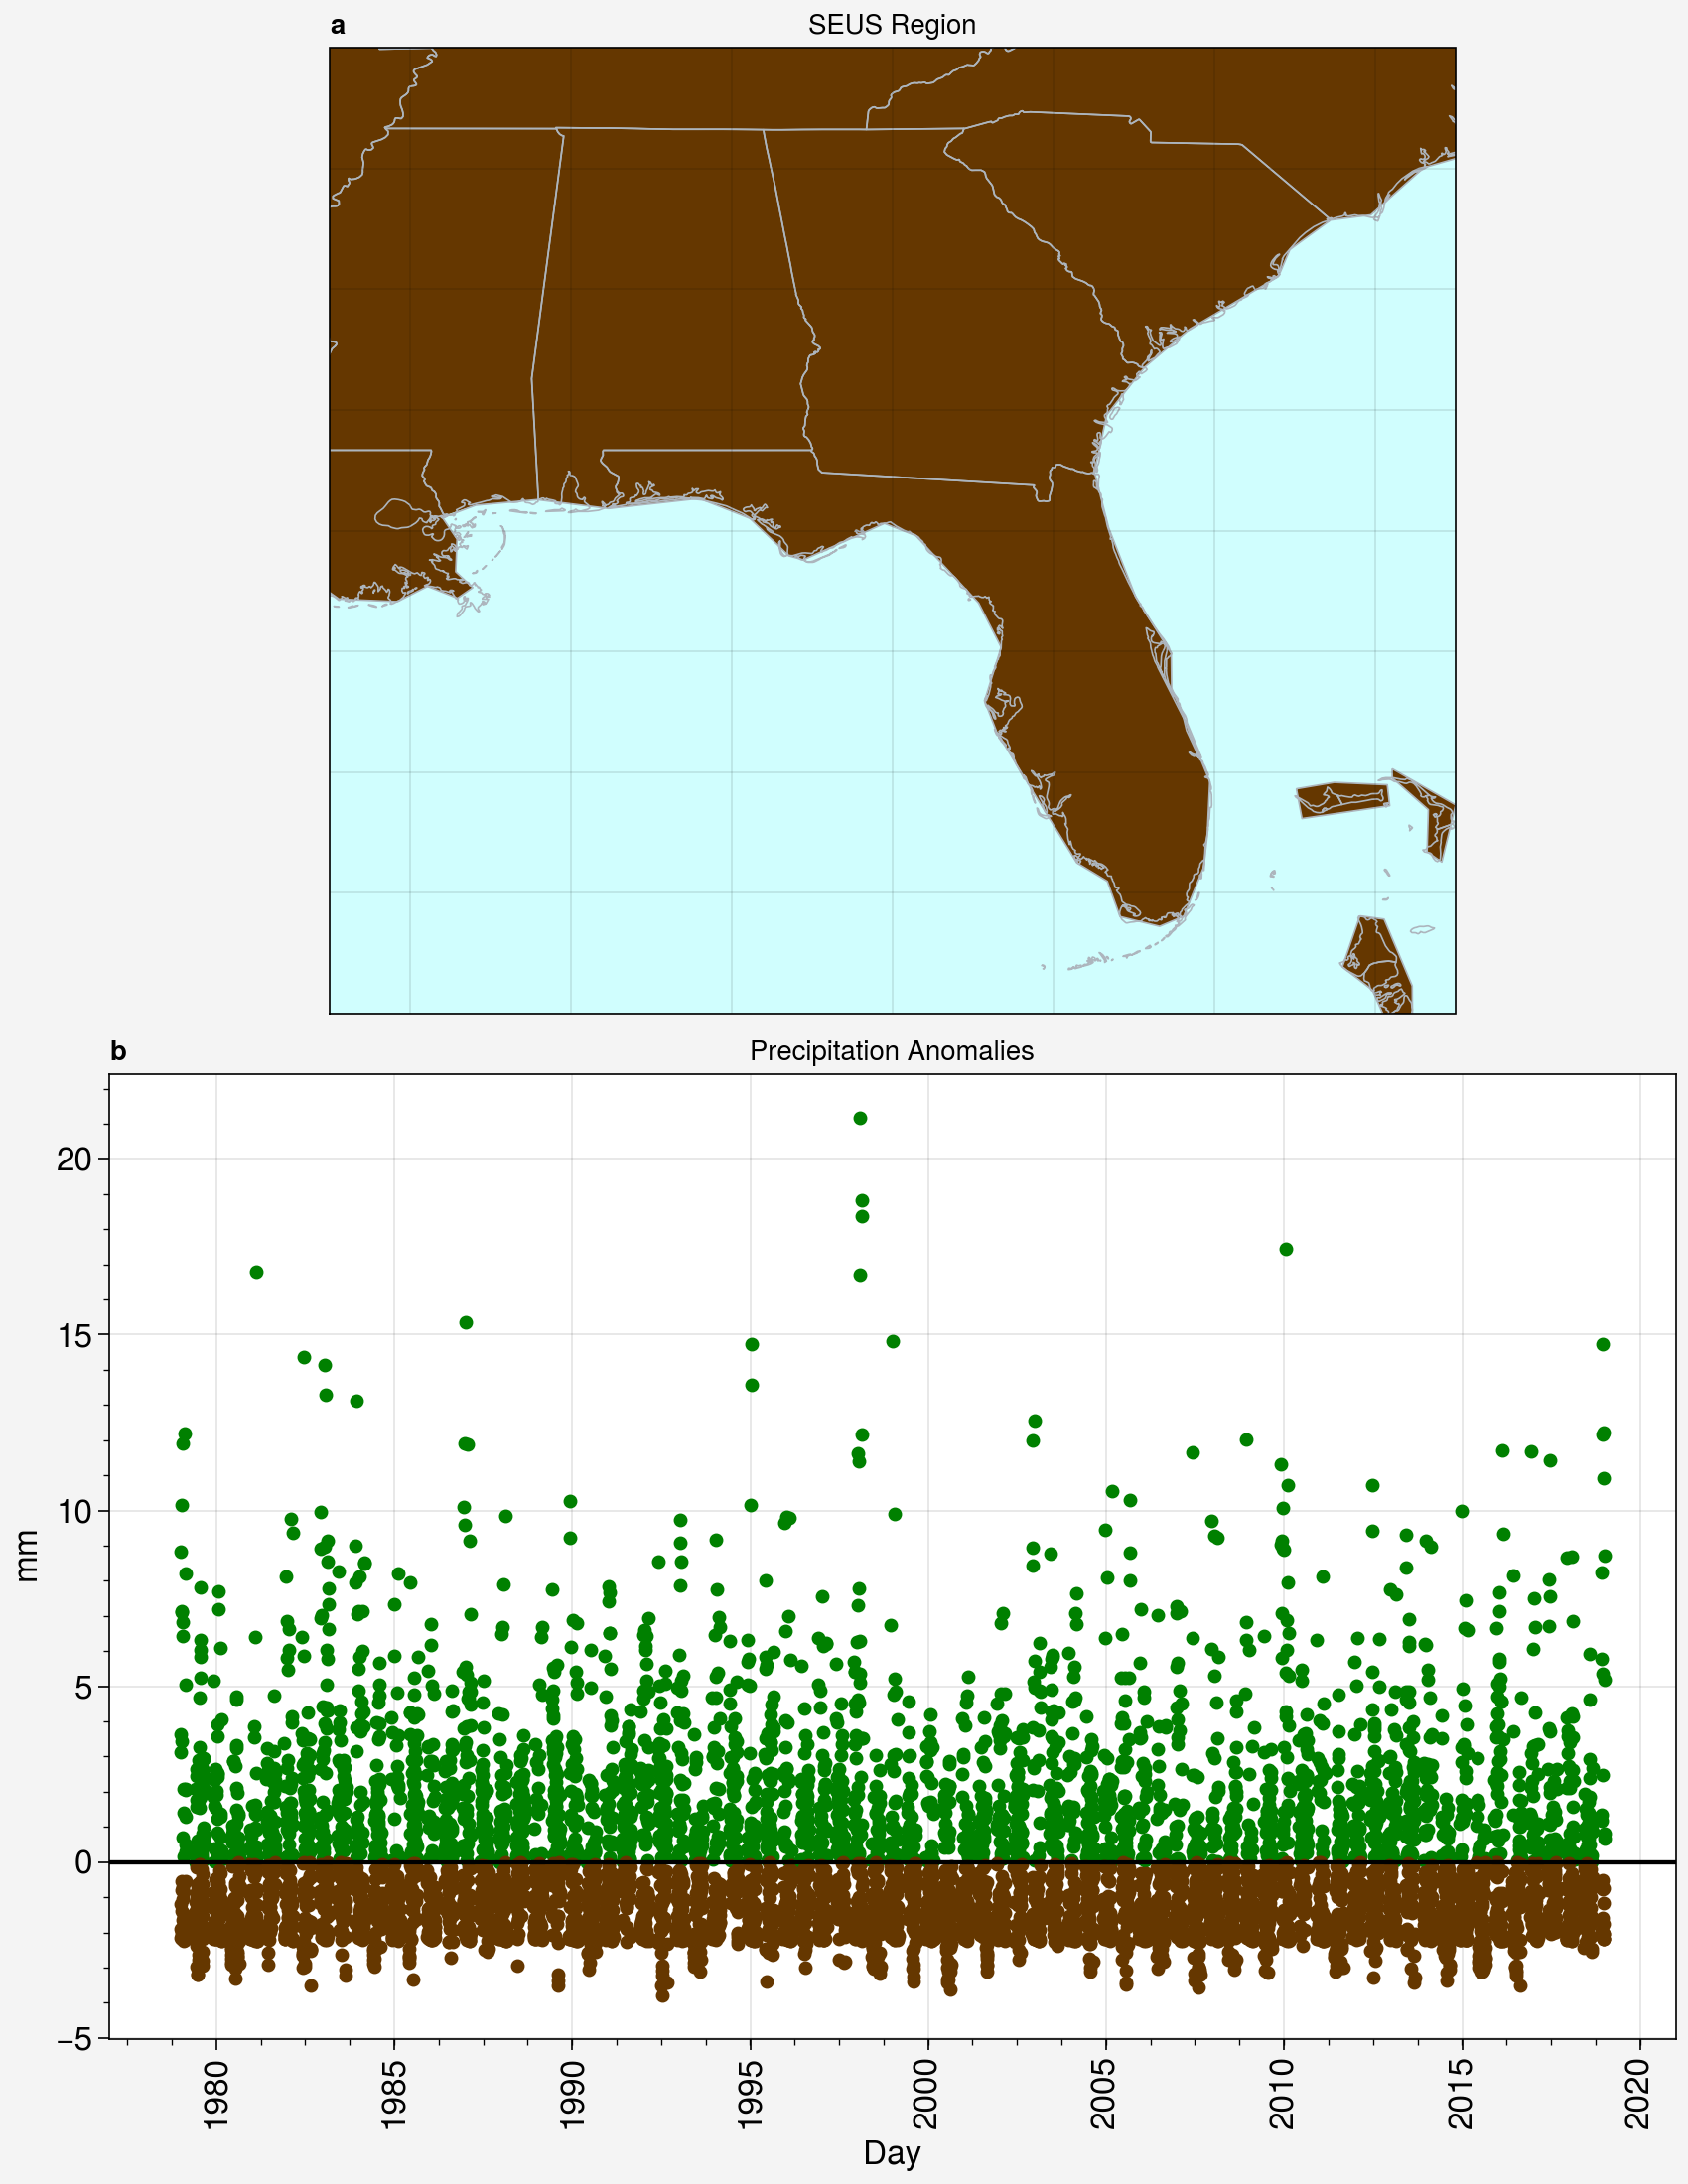

In [15]:
winter=[12,1,2]
summer=[6,7,8]
latreg=[24.0,36.0]
lonreg=[269.0,283.0]
f,axs=pplt.subplots(ncols=1,nrows=2,figsize=(8.5,11), 
                   proj=['pcarree'],proj_kw={'lon_0': 290})

# Plot Map
axs[0].format(title='SEUS Region', lonlim=lonreg,latlim=latreg,
          land=True, landcolor='brown', facecolor='pale blue',
          coastcolor='gray5', borderscolor='gray5', innerborderscolor='gray5',
          coast=True, borders=True, borderslinewidth=0.8,abc=True,fontsize=12)
axs[0].add_feature(cfeature.STATES,edgecolor='gray5')


# Plot Anomalies
for seas in [winter,summer]:
    
    da=ds_target['precip'].sel(time=ds_target['precip']['time.month'].isin(seas))
    tmp_pos=da.where(da>0)
    tmp_neg=da.where(da<0)
    axs[1].plot(tmp_pos['time'].values,tmp_pos.values,'g.',markersize=8,linestyle='None')
    axs[1].plot(tmp_neg['time'].values,tmp_neg.values,'brown',marker='.',markersize=8,linestyle='None')
    axs[1].axhline(0.0,color='k')
    axs[1].format(abc=True,ylabel='$mm$',xlabel='Day',
                  fontsize=12,title='Precipitation Anomalies')

f.save('../figs/Figure1.jpg')

### Figures 2 and 3
Architecture diagrams created by hand in Powerpoint

### Figure 4: Histogram of Winter and Summer Accuracy of MLR-I and FC-NN

fnames_indices='../data/fnn/model_output.*.nc'
ds_model_indices=xr.open_mfdataset(fnames_indices,combine='nested',concat_dim='seas')
ds_model_indices['seas']=['DJF','JJA']

In [16]:
ds_model_indices

<xarray.Dataset>
Dimensions:     (time: 6083, features: 10, rules: 2, seas: 2, model_type: 2, model: 100, cat: 2)
Coordinates:
  * time        (time) datetime64[ns] 1980-06-03 1980-06-04 ... 2015-02-28
  * features    (features) object 'RMM_amp' 'RMM_phase' ... 'pdo' 'pnaregimes'
  * rules       (rules) object 'lrp.alpha_1_beta_0' 'lrp.z'
  * model       (model) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * cat         (cat) object 'Lower' 'Upper'
    dayofyear   (time) float64 dask.array<chunksize=(6083,), meta=np.ndarray>
  * model_type  (model_type) object 'logmodel_med' 'nnmodel_med'
  * seas        (seas) <U3 'DJF' 'JJA'
Data variables:
    lrp         (seas, model_type, model, rules, time, features) float32 dask.array<chunksize=(1, 2, 100, 2, 6083, 10), meta=np.ndarray>
    pred        (seas, model_type, model, time) float64 dask.array<chunksize=(1, 2, 100, 6083), meta=np.ndarray>
    verif       (seas, model_type, model, time) float64 dask.array<chunksize=(1, 2, 100, 6083), meta=np.ndarray>
    probs       (seas, model_type, model, time, cat) float32 dask.array<chunksize=(1, 2, 100, 6083, 2), meta=np.ndarray>
    acc         (seas, model_type, model) float64 dask.array<chunksize=(1, 2, 100), meta=np.ndarray>
    val_acc     (seas, model_type, model) float64 dask.array<chunksize=(1, 2, 100), meta=np.ndarray>
    precip      (seas, model_type, time) float32 dask.array<chunksize=(1, 2, 6083), meta=np.ndarray>

DJF logmodel_med 0 0
DJF nnmodel_med 0 1
JJA logmodel_med 1 0
JJA nnmodel_med 1 1


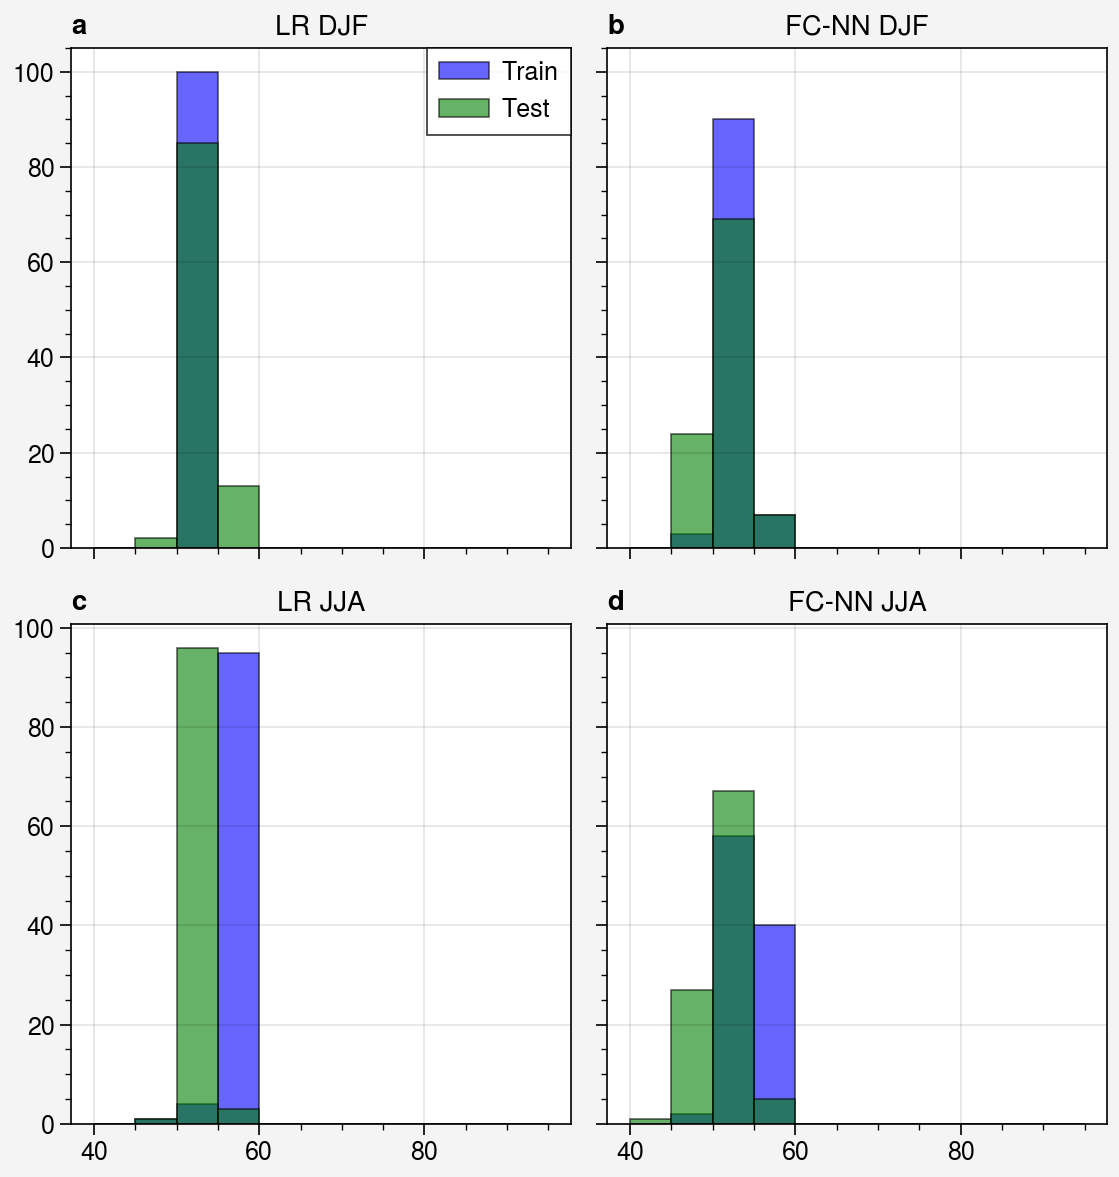

In [17]:
hist_bins=np.arange(40,100,5)
hist_multipanel(ds_model_indices,hist_bins,['LR','FC-NN'],fname='../figs/Figure4.jpg')

### Figure 5: Reliability

In [18]:
# train=0,test=1
train_test=np.zeros((len(ds_model_indices['time'])))
train_test[2403::]=1
da_tt=xr.DataArray(train_test,coords={'time':ds_model_indices['time']},dims=['time']).to_dataset(name='tt')
ds_model_indices=xr.merge([da_tt,ds_model_indices])

reliability_multi(ds_model_indices,['LR','FC-NN'],fname='../figs/Figure5.jpg')

### Figure 6

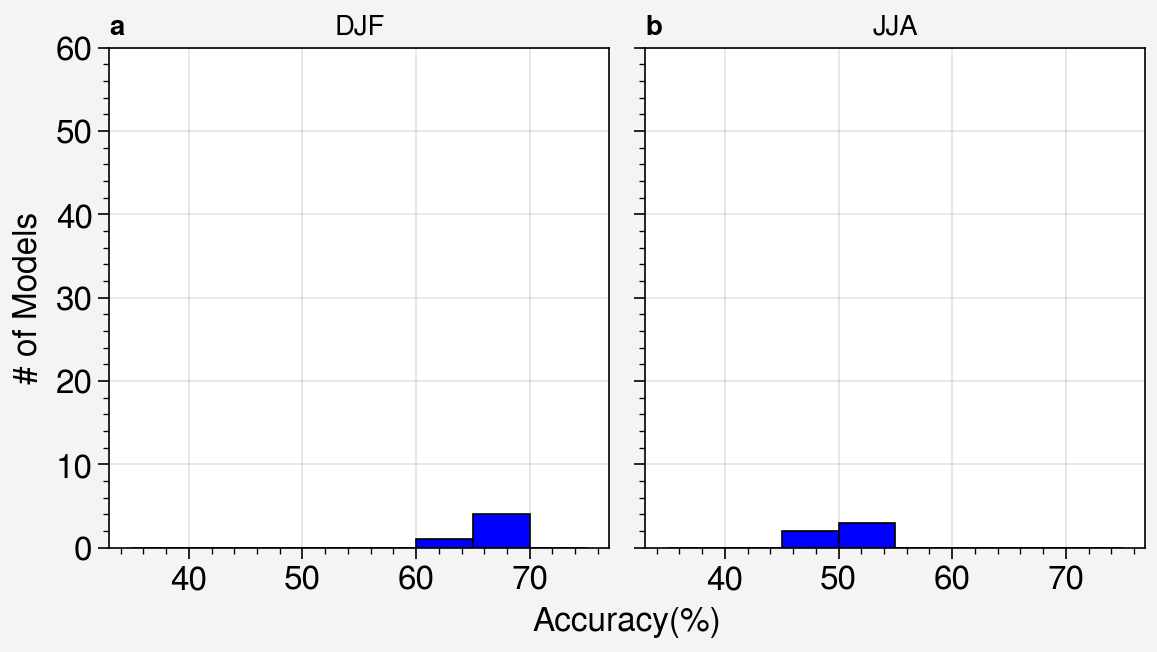

In [19]:
hist_bins=np.arange(35,80,5)
f,axs=pplt.subplots(nrows=1,ncols=2)
hs=[]

for i,seas in enumerate(['DJF','JJA']):
#    for (tt,c) in zip(['Train-Val','Test'],['b','g']):
    for (tt,c) in zip(['Test'],['b']):
        
        cnn_val_fname='../data/cnn_test/model_validate.'+tt+'.'+seas+'.cnn_cat.*.nc'
        ds_cnn_val=xr.open_mfdataset(cnn_val_fname,combine='nested',concat_dim='model')

        h=axs[0,i].hist(ds_cnn_val['acc'].values*100,hist_bins,
                        edgecolor='k',color=c,alpha=1)
        hs.append(h)
    
        # Format subplot panel
        axs[0,i].format(title=seas,abc=True,xlabel='Accuracy(%)',
                        ylabel='# of Models',fontsize=12,ylim=(0,60), 
                        ylocator=10)

# Add custom legend
#axs[0,0].legend(hs, labels=['Train-Val','Test'],ncols=1, loc='ul') 

# Save Figure
f.save('../figs/Figure6.jpg')

### Figure 7

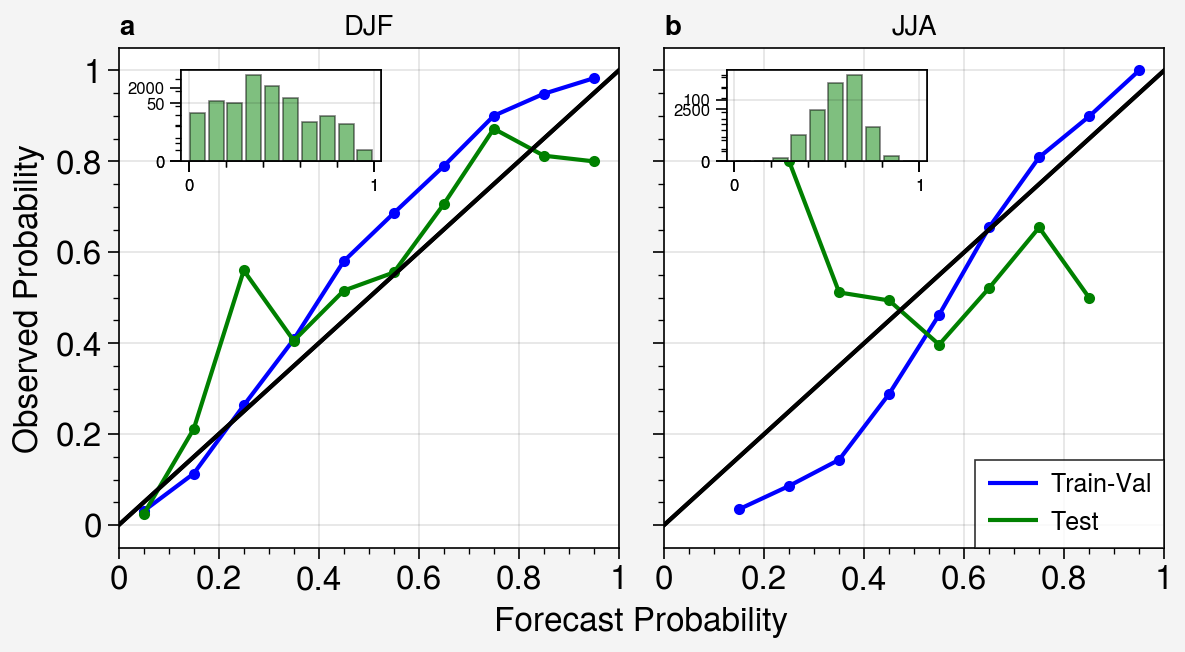

In [20]:
rel_bins=np.arange(0,1.1,0.1)   
f,axs=pplt.subplots(nrows=1,ncols=2)


for i,seas in enumerate(['DJF','JJA']):
    hs=[]
    for (tt,c) in zip(['Train-Val','Test'],['b','g']):
        
        cnn_val_fname='../data/cnn_test/model_validate.'+tt+'.'+seas+'.cnn_cat.*.nc'
        ds_cnn_val=xr.open_mfdataset(cnn_val_fname,combine='nested',concat_dim='model')
        
        # Calculate reliability
        rel=xs.reliability(ds_cnn_val['verif']==1,ds_cnn_val['probs'].sel(cat='Positive'),dim=['model','time'],
                           probability_bin_edges=rel_bins)
        h=axs[0,i].plot(rel['forecast_probability'],rel.values,c)
        axs[0,i].plot(rel['forecast_probability'],rel.values,c+'.')
        hs.append(h)
        
        axs[0,i].format(xtickminor=True,ytickminor=True,title=seas,
                        xlabel='Forecast Probability',ylabel='Observed Probability',
                        abc=True,fontsize=12)
        
        # Perfect reliability line
        axs[0,i].plot(rel_bins,rel_bins,'k')
            
        # Histogram inset
        axi = axs[0,i].inset([0.125, 0.8, 0.4, 0.2], transform='data',zoom=False)
        axi.bar(rel['forecast_probability'],rel['samples'].values,color=c,alpha=0.5)
        axi.format(xtickminor=True,ytickminor=True,fontsize=6)
        
    # Add custom legend
    axs[-1,-1].legend(hs, labels=['Train-Val','Test'],ncols=1, loc='lr')

    # Save Figure
f.save('../figs/Figure7.jpg')

### Figures 8, 9, 10, 11: Composites

In [21]:
ifname_lrp='../data/cnn_test/model_lrpcomp.*.cnn_cat.nc'
ifname_comp='../data/cnn_test/model_anomscomp.*.cnn_cat.nc'
    
ds_lrp=xr.open_mfdataset(ifname_lrp,combine='nested',concat_dim='seas')
ds_comp=xr.open_mfdataset(ifname_comp,combine='nested',concat_dim='seas')

ds_lrp['seas']=['DJF','JJA']
ds_comp['seas']=['DJF','JJA']

In [22]:
ds_comp['z850'].max().values

array(505.78333, dtype=float32)

In [23]:
ds_comp['z850'].min().values

array(-505.5307, dtype=float32)

In [24]:
lrp_norm=ds_lrp/ds_lrp.max(dim=['lat','lon','var'])

#### Plot Composites (combined Train-Val and Test)

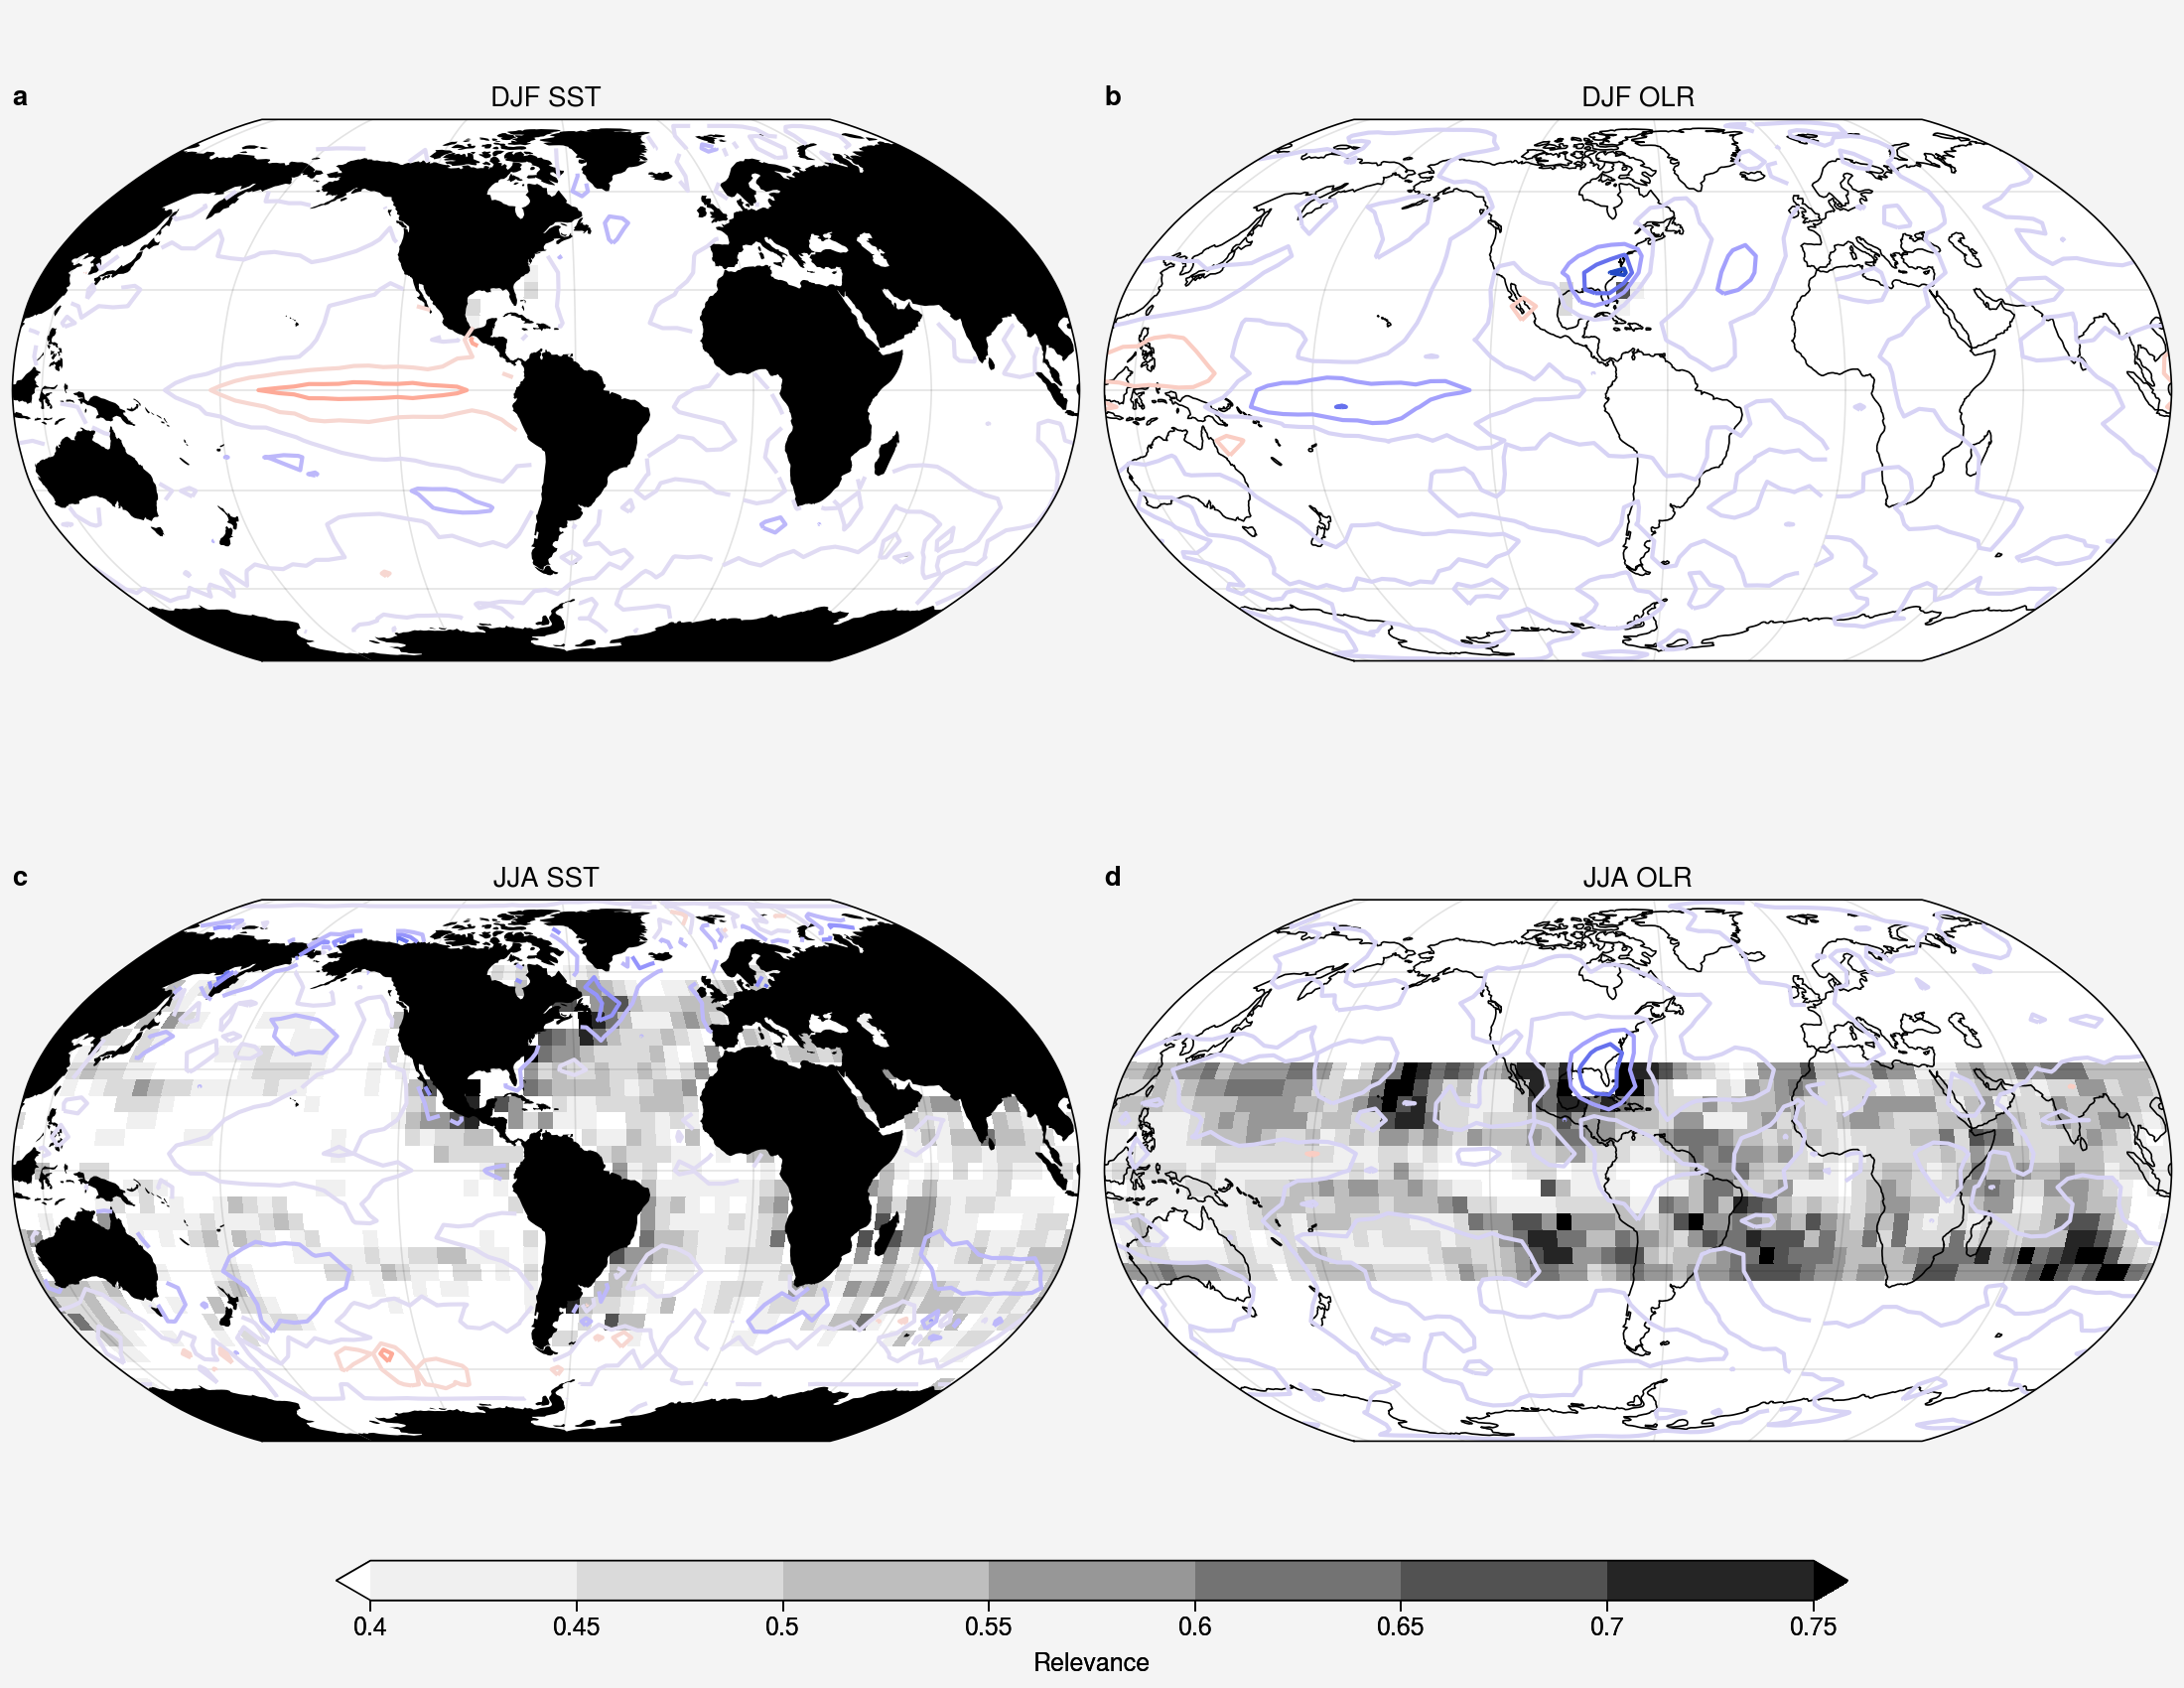

In [ ]:
plotCompLRPGlobe(lrp_norm['lrp'].sel(cat='Positive'),
                 ds_comp.sel(cat='Positive'),
                 file='../figs/Figure8.jpg')

plotCompLRPCirc(lrp_norm['lrp'].sel(cat='Positive'),
                ds_comp.sel(cat='Positive'),
                file='../figs/Figure9.jpg')

plotCompLRPGlobe(lrp_norm['lrp'].sel(cat='Negative'),
                 ds_comp.sel(cat='Negative'),
                 file='../figs/Figure10.jpg')

plotCompLRPCirc(lrp_norm['lrp'].sel(cat='Negative'),
                ds_comp.sel(cat='Negative'),
                file='../figs/Figure11.jpg')

### Confusion Matrices/Contingency Table for CNN model (A3.1)

In [ ]:
ds_list=[]
for seas,im in zip(['DJF','JJA'],[0,0]):
    cnn_val_fname='../data/cnn_test/model_validate.*.'+seas+'.cnn_cat.'+str(im)+'.nc'
    ds_tmp=xr.open_mfdataset(cnn_val_fname,combine='by_coords')
    ds_list.append(ds_tmp)
ds_cnn_val=xr.combine_nested(ds_list,concat_dim='seas')
ds_cnn_val['seas']=['DJF','JJA']

make_cm(ds_cnn_val,file='../figs/FigureD1.jpg')


### Power Spectra (S4,S5) and De-Correlation Times (Table 2)

In [ ]:
ds_anoms=getFields()

#### Settings

In [64]:
N=14610
N2=int(N/2+1)
h=np.arange(0,N2)

#### Calculate and Plot Power Spectra and Red Noise (S1,S2)

In [65]:
for seas,fnum in zip(['DJF','JJA'],['1','2']):
    
    # Get Time Series Associated with Patterns
    ds_ts_pos=getTS(ds_anoms,ds_comp.sel(cat='Positive'),seas,file='')
    ds_ts_neg=getTS(ds_anoms,ds_comp.sel(cat='Negative'),seas,file='')

    # Calculate Power Spectra
    ds_Pneg=powerSpectra(ds_neg,N)
    ds_Ppos=powerSpectra(ds_pos,N)

    # Calculate Red Noise
    r_list_neg=rednoise(ds_neg,h)
    r_list_pos=rednoise(ds_pos,h)

    # Plot Power Spectra and Red Noise
    f, axs = pplt.subplots(nrows=3,ncols=2,share=False)
    for i,(ax,v) in enumerate(zip(axs,list(ds_Pneg.keys()))):
    
        # Negative
        var_scale=np.sum(ds_Pneg[v].values)/np.sum(r_list_neg[i])
        ax.plot(1/ds_Pneg['freq'][1::],ds_Pneg[v][1::]/ds_Pneg['freq'][1::],
                color='brown',alpha=0.25)
        ax.plot(1/ds_Pneg['freq'][1::],r_list_neg[i][1::]*var_scale/ds_Pneg['freq'][1::],
                color='brown',linestyle='--')
        
        # Positive
        var_scale=np.sum(ds_Ppos[v].values)/np.sum(r_list_pos[i])
        ax.plot(1/ds_Ppos['freq'][1::],ds_Ppos[v][1::]/ds_Ppos['freq'][1::],
                color='green',alpha=0.25)
        ax.plot(1/ds_Ppos['freq'][1::],r_list_pos[i][1::]*var_scale/ds_Ppos['freq'][1::],
                color='green',linestyle='--')
    
        ax.format(title=v.upper(),xlabel='Period (Days)',
                  yscale='log',yformatter='log',xscale='log',xformatter='log',abc=True)

    f.format(ylabel='Power Density (Units$^{2}$Cycle$^{-1}$Day$^{-1}$)')
    f.save('../figs/S'+fnum+'.jpg')

MemoryError: Unable to allocate 25.2 GiB for an array with shape (58440, 241, 480) and data type float32